# Caroline on robust steroids


As we know, BIM produces logic and memory chips using copper, silicon, germanium and plastic. 

Each chip has the following consumption of materials:

| chip   | copper | silicon | germanium | plastic |
|:-------|-------:|--------:|----------:|--------:|
|Logic   |    0.4 |       1 |           |       1 |
|Memory  |    0.2 |         |         1 |       1 |

BIM hired Caroline to manage the acquisition and the inventory of these raw materials. 

Caroline conducted a data analysis which lead to the following prediction of monthly demands for her trophies: 

| chip   | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:-------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|Logic   |  88 | 125 | 260 | 217 | 238 | 286 | 248 | 238 | 265 | 293 | 259 | 244 |
|Memory  |  47 |  62 |  81 |  65 |  95 | 118 |  86 |  89 |  82 |  82 |  84 | 66  |

As you recall, BIM has the following stock at the moment:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   480|  1000 |     1500|  1750 |

BIM would like to have at least the following stock at the end of the year:

|copper|silicon|germanium|plastic|
|-----:|------:|--------:|------:|
|   200|   500 |      500|  1000 |

Each product can be acquired at each month, but the unit prices vary as follows:

| product  | Jan | Feb | Mar | Apr | May | Jun | Jul | Aug | Sep | Oct | Nov | Dec |
|:---------|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|copper    |   1 |   1 |   1 |   2 |   2 |   3 |   3 |   2 |   2 |   1 |   1 |   2 |
|silicon   |   4 |   3 |   3 |   3 |   5 |   5 |   6 |   5 |   4 |   3 |   3 |   5 |
|germanium |   5 |   5 |   5 |   3 |   3 |   3 |   3 |   2 |   3 |   4 |   5 |   6 |
|plastic   | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 | 0.1 |

The inventory is limited by a capacity of a total of 9000 units per month, regardless of the composition of products in stock. 
The holding costs of the inventory are 0.05 per unit per month regardless of the product.

Caroline cannot spend more than 5000 per month on acquisition.

Note that Caroline aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. 
The production is made to order, meaning that no inventory of chips is kept.

Please help Caroline to model the material planning and solve it with the data above. 

In [1]:
import sys
if 'google.colab' in sys.modules:
    import shutil
    if not shutil.which('pyomo'):
        !pip install -q pyomo
        assert(shutil.which('pyomo'))

    # cbc
    !apt-get install -y -qq coinor-cbc

In [2]:
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

demand_data = '''
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
Logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
Memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
'''

demand_chips = pd.read_csv(StringIO(demand_data), index_col='chip')
display(demand_chips)

price_data = '''
product, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
copper, 1, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2
silicon, 4, 3, 3, 3, 5, 5, 6, 5, 4, 3, 3, 5
germanium, 5, 5, 5, 3, 3, 3, 3, 2, 3, 4, 5, 6
plastic, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
'''

price = pd.read_csv(StringIO(price_data), index_col='product')
display(price)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [3]:
use = dict()
use['Logic'] = {'silicon': 1, 'plastic': 1, 'copper': 4}
use['Memory'] = {'germanium': 1, 'plastic': 1, 'copper': 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
material_demand = use.dot(demand_chips)

existing = pd.Series({'silicon': 1000, 'germanium': 1500, 'plastic': 1750, 'copper': 4800 })
eot_inventory = pd.Series({'silicon':  500, 'germanium':  500, 'plastic': 1000, 'copper': 2000 })


def initialize_problem_data():
    problem_data = {
        "price": price.copy(deep=True),
        "inventory_cost": 0.05,
        "material_demand": material_demand.copy(deep=True),
        "demand_chips_ref": demand_chips.copy(deep=True),
        "demand_chips_simulation": demand_chips.copy(deep=True),
        "use": use.copy(deep=True),
        "existing": existing.copy(deep=True),
        "eot_inventory": eot_inventory.copy(deep=True),
        "stock_limit": 9000,
        "month_budget": 2500
    }
    return problem_data

problem_data = initialize_problem_data()

for key, df in problem_data.items():
    display(key)
    display(df)
    print()

'price'

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
product,,,,,,,,,,,,
copper,1.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0
silicon,4.0,3.0,3.0,3.0,5.0,5.0,6.0,5.0,4.0,3.0,3.0,5.0
germanium,5.0,5.0,5.0,3.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,6.0
plastic,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


'inventory_cost'

0.05

'material_demand'

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


'demand_chips_ref'

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


'demand_chips_simulation'

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


'use'

,Logic,Memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


'existing'

silicon      1000
germanium    1500
plastic      1750
copper       4800
dtype: int64

'eot_inventory'

silicon       500
germanium     500
plastic      1000
copper       2000
dtype: int64

'stock_limit'

9000

'month_budget'

2500

In [4]:
def ShowTableOfPyomoVariables(X, I, J):
    return pd.DataFrame.from_records([[pyo.value(X[i,j]) for j in J] for i in I], index=I, columns=J)

In [5]:
def BIMProductAcquisitionAndInventory(problem_data):
    demand = problem_data["use"].dot( problem_data["demand_chips_ref"] )
    acquisition_price = problem_data["price"]
    existing = problem_data["existing"]
    desired = problem_data["eot_inventory"]
    stock_limit = problem_data["stock_limit"]
    month_budget = problem_data["month_budget"]
    
    m = pyo.ConcreteModel( 'Product acquisition and inventory' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var(m.PT, within=pyo.NonNegativeReals)
    m.s = pyo.Var(m.PT, within=pyo.NonNegativeReals)
    
    @m.Param(m.PT)
    def pi(m,p,t):
        return acquisition_price.loc[p][t]
    
    @m.Param(m.PT)
    def h(m,p,t): 
        return .05 # the holding cost
    
    @m.Param(m.PT)
    def delta(m,t,p):
        return demand.loc[t,p]
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.pi[p,t] * m.x[p,t] for p in m.P for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.h[p,t] * m.s[p,t] for p in m.P for t in m.T )
    
    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint(m.PT)
    def balance(m, p, t):
        if t == first:
            return existing[p] + m.x[p,t] == m.delta[p,t] + m.s[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] == m.delta[p,t] + m.s[p,t]
        
    @m.Constraint(m.P)
    def finish(m, p):
        return m.s[p,last] >= desired[p]
    
    @m.Constraint(m.T)
    def inventory(m, t):
        return pyo.quicksum( m.s[p,t] for p in m.P ) <= stock_limit
    
    @m.Constraint(m.T)
    def budget(m, t):
        return pyo.quicksum( m.pi[p,t]*m.x[p,t] for p in m.P ) <= month_budget
    
    return m

m = BIMProductAcquisitionAndInventory(problem_data)
pyo.SolverFactory('mosek').solve(m)
print(m.total_cost())

problem_data["purchases"] = ShowTableOfPyomoVariables(m.x, m.P, m.T)
problem_data["stock"] = ShowTableOfPyomoVariables(m.s, m.P, m.T)

display(problem_data["purchases"])
display(problem_data["stock"])

23580.340833333335


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0.0,833.333333,225.666667,833.333333,0.000000,0.0,0.0,0.00,368.666667,0.0,0.0,0.0
plastic,0.0,0.000000,0.000000,0.000000,0.000000,0.0,266.0,327.00,722.000000,0.0,343.0,1310.0
copper,666.0,0.000000,1823.000000,0.000000,310.783333,0.0,0.0,1233.65,476.566667,2500.0,2465.7,682.3
germanium,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912.0,1620.333333,1586.0,2202.333333,1964.333333,1678.333333,1430.333333,1192.333333,1296.0,1003.0,744.0,500.0
plastic,1615.0,1428.000000,1087.0,805.000000,472.000000,68.000000,0.000000,0.000000,375.0,0.0,0.0,1000.0
copper,5020.0,4396.000000,5017.0,4019.000000,3187.783333,1807.783333,643.783333,747.433333,0.0,1164.0,2425.7,2000.0
germanium,1453.0,1391.000000,1310.0,1245.000000,1150.000000,1032.000000,946.000000,857.000000,775.0,693.0,609.0,543.0


In [6]:
m = BIMProductAcquisitionAndInventory(problem_data)

pyo.SolverFactory('cbc').solve(m)
problem_data["purchases"] = ShowTableOfPyomoVariables(m.x, m.P, m.T)
problem_data["stock"] = ShowTableOfPyomoVariables(m.s, m.P, m.T)

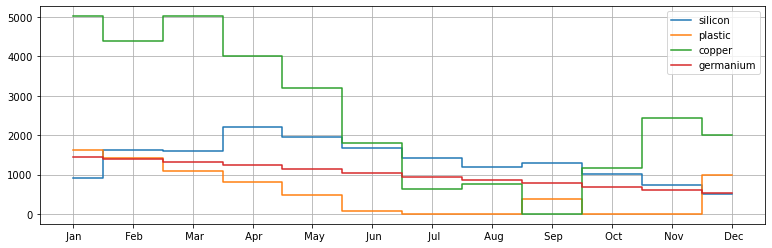

In [7]:
import matplotlib.pyplot as plt, numpy as np
stock = problem_data["stock"]
ax = stock.T.plot(drawstyle='steps-mid', grid=True, figsize=(13,4))
ax.set_xticks(np.arange(len(stock.columns)), stock.columns);

In [8]:
################# SIMULATION OF THE REAL-TIME PERFORMANCE #######################

# Conceptual
#1) Decide on how to perturb the demand
#2) Decide what is done given the perturbed demand - which product has the most priority
#3) Decide what data to collect along the simulation

# Implementation
#1) Create a function that given demand trajectory and solution simulates by moving step by step, calling a sub-function
#2) Create a function that given initial state at time t-1 executes the "what do do" strategy so that we obtain the immediate decisions 
#3) Update the data and move to the next state

# How to represent a demand trajectory? Data frame with columns as period names
# What data to output per period: 
# (i) missed demand per each chip category, 
# (ii) inventory for each raw material (start or end?)

# Create a class to store all the data of the current solution so that it's easy to retrieve
import numpy as np
def simulation_per_trajectory(purchases, existing, demand_chips, use):
    
    # Set up the table to store inventory evolution
    inventory = pd.DataFrame(index = purchases.index, columns = purchases.columns)
    inventory = pd.concat([pd.DataFrame(existing, index = existing.index, columns = ["existing"]), inventory], axis = 1)
    
    #print(inventory)
    # Set up the DF to store missed demand information
    missed_demand = pd.DataFrame(np.zeros((len(demand_chips.index), len(purchases.columns))), index = demand_chips.index, columns = purchases.columns)
    
    # proper simulation
    for period in inventory.columns[1:]:
        minimize_missed_demand_in_period(inventory, missed_demand, purchases, existing, demand_chips, use, period)
        
    return inventory.iloc[:, 1:], missed_demand

def minimize_missed_demand_in_period(inventory, missed_demand, purchases, existing, demand_chips, use, period = None):
    m = pyo.ConcreteModel('In period')
    
    periods  = inventory.columns
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.P = pyo.Set( initialize=list(use.columns)  )
    m.M = pyo.Set( initialize=list(use.index) )
    # decision variable: nb of chips to produce >= 0
    m.x = pyo.Var( m.P, within=pyo.NonNegativeReals )
    # decision variable: missed demand
    m.s = pyo.Var( m.P, within=pyo.NonNegativeReals )
    
    # constraint: per resource we don't use more than there is
    @m.Constraint(m.M)
    def resource_constraint(m, i):
        return pyo.quicksum(m.x[p] * use.loc[i, p] for p in m.P) <= inventory.loc[i, prev[period]] + purchases.loc[i, period]
    
    # constraint: production + missed demand = total demand in this period
    @m.Constraint(m.P)
    def produced_plus_unmet(m, p):
        return m.x[p] + m.s[p] == demand_chips.loc[p, period]
    
    # objective - minimize the missed demand
    @m.Objective( sense=pyo.minimize )
    def total_unmet(m):
        return pyo.quicksum(m.s[p] for p in m.P)
    
    # solve
    pyo.SolverFactory('cbc').solve(m)
    
    # update inventory
    for i in m.M:
        inventory.loc[i, period] = inventory.loc[i, prev[period]] + purchases.loc[i, period] \
                - sum([pyo.value(m.x[p]) * use.loc[i, p] for p in m.P])
    
    # update missed demand
    for p in m.P:
        missed_demand.loc[p, period] = pyo.value(m.s[p])
    
    return 0

def simulate_performance(problem_data, n = 50, rho = 0.2):
    results = []

    for i in range(n):
        perturbed_demand = problem_data["demand_chips_simulation"].applymap(lambda x: x * (1 + rho * (1 - 2 * np.random.rand())))
        inv, md = simulation_per_trajectory(problem_data["purchases"], problem_data["existing"], perturbed_demand, use)
        results.append({"inventory": inv, "missing_demand": md})
        
    MissingDemand = pd.concat([i["missing_demand"] for i in results], keys = [i for i in range(len(results))])
    MissingDemand = MissingDemand.astype('float').swaplevel()
    
    InventoryEvolution = pd.concat([i["inventory"] for i in results], keys = [i for i in range(len(results))])
    InventoryEvolution = InventoryEvolution.astype('float').swaplevel()

    return {"MissingDemand": MissingDemand, 
            "InventoryEvolution": InventoryEvolution}

def report(MissingDemand, InventoryEvolution, problem_data, plot_name = "Nominal"):
    to_analyze = MissingDemand
    
    # list to store DFs with per-group computed quantiles at various levels
    average_missed_demand = to_analyze.groupby(level = 0).mean().transpose()

    # build a plot with as many subplots as there are chip types
    fig, axis = plt.subplots(figsize = (11, 4))
    average_missed_demand.plot(ax = axis, drawstyle='steps-mid',grid=True)#, xticks = average_missed_demand.index)
    plt.xticks(ticks = np.arange(len(average_missed_demand.index)), labels = average_missed_demand.index)
    #axis.set_xticks(ticks=average_missed_demand.index, labels=average_missed_demand.index)
    axis.set_title("Missed demand of chips under " + str(rho * 100) + "% uncertainty")

    fig.tight_layout(pad=3.0)
    plt.savefig("Missed_demand_" + plot_name + ".pdf")
    
    realized_inv_cost = InventoryEvolution.groupby(level = 0).mean().sum(axis = 1).sum() * problem_data["inventory_cost"]
    print("Purchasing cost: ", (problem_data["price"] * problem_data["purchases"]).sum().sum())
    print("Assumed inventory cost: ", (problem_data["stock"] * problem_data["inventory_cost"]).sum().sum())
    print("Simulated inventory cost:", str(realized_inv_cost))
    print("Simulated average missing demand: ", dict(to_analyze.groupby(level = 0).mean().sum(axis = 1)))

================= Nominal model =====================
Purchasing cost:  20309.76666666667
Assumed inventory cost:  3270.574166666667
Simulated inventory cost: 3291.765636502667
Simulated average missing demand:  {'Logic': 3.9475693836, 'Memory': 10.742505826399999}


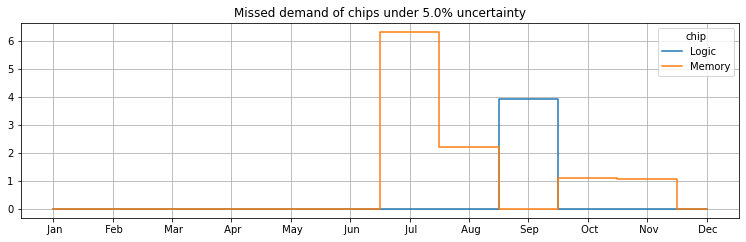

In [9]:
rho = 0.05
N_sim = 50

print("================= Nominal model =====================")
problem_data["demand_chips_ref"] = demand_chips
m = BIMProductAcquisitionAndInventory(problem_data)

pyo.SolverFactory('mosek').solve(m)
problem_data["purchases"] = ShowTableOfPyomoVariables(m.x, m.P, m.T )
problem_data["stock"] = ShowTableOfPyomoVariables( m.s, m.P, m.T )

SimResults = simulate_performance(problem_data, N_sim, rho)

report(SimResults["MissingDemand"],
       SimResults["InventoryEvolution"],
       problem_data,
       "nominal")

Purchasing cost:  20309.76666666667
Assumed inventory cost:  3270.574166666667
Simulated inventory cost: 3291.765636502667
Simulated average missing demand:  {'Logic': 3.9475693836, 'Memory': 10.742505826399999}


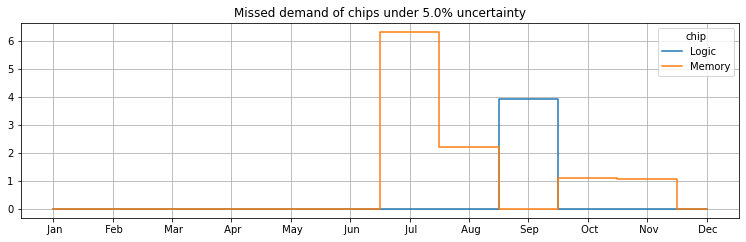

In [10]:
report(SimResults["MissingDemand"],
       SimResults["InventoryEvolution"],
       problem_data,
       "nominal")

In [11]:
print("================= Robust model =====================")
problem_data["demand_chips_ref"] = np.round(demand_chips * 1.05)
m = BIMProductAcquisitionAndInventory(problem_data)

pyo.SolverFactory('cbc').solve(m)
print(m.total_cost())
problem_data["purchases"] = ShowTableOfPyomoVariables( m.x, m.P, m.T )
problem_data["stock"] = ShowTableOfPyomoVariables( m.s, m.P, m.T )

# SimResults = simulate_performance(problem_data, 
#                                   N_sim, 
#                                   rho)

# report(SimResults["MissingDemand"],
#        SimResults["InventoryEvolution"],
#        problem_data,
#        "robust")

================= Robust model =====================
25316.335814


In [25]:
def report(MissingDemand, InventoryEvolution, problem_data, plot_name = "Nominal"):
    to_analyze = MissingDemand
    
    # list to store DFs with per-group computed quantiles at various levels
    average_missed_demand.append(to_analyze.groupby(level = 0).mean())

    # build a plot with as many subplots as there are chip types
    fig, axis = plt.subplots((len(to_analyze.index.levels[0])), figsize = (11, 8))
    average_missed_demand.plot(ax, ax = axis)
    ax.set_title("Missed demand of chips under p/m " + str(rho * 100) + "% uncertainty")

    fig.tight_layout(pad=3.0)
    plt.savefig("Missed_demand_" + plot_name + ".pdf")
    
    realized_inv_cost = InventoryEvolution.groupby(level = 0).mean().sum(axis = 1).sum() * problem_data["inventory_cost"]
    print("Purchasing cost: ", (problem_data["price"] * problem_data["purchases"]).sum().sum())
    print("Assumed inventory cost: ", (problem_data["stock"] * problem_data["inventory_cost"]).sum().sum())
    print("Simulated inventory cost:", str(realized_inv_cost))
    print("Simulated average missing demand: ", dict(to_analyze.groupby(level = 0).mean().sum(axis = 1)))

In [ ]:
# It shall be achieved by formulating the ordering decisions as LDR's of the
# observed demands up to this time period

def RobustOptimization(problem_data, adaptive=True, uncertainty_level=0.0):
    ######### PROBLEM DATA
    #############################################
    #############################################
    use = problem_data["use"]
    #demand = problem_data["use"].dot( problem_data["demand_chips_ref"] )
    acquisition_price = problem_data["price"]
    existing = problem_data["existing"]
    desired = problem_data["eot_inventory"]
    stock_limit = problem_data["stock_limit"]
    month_budget = problem_data["month_budget"]
    inventory_cost = .05
    use = problem_data["use"]

    ######### MODEL AND DATA DEFINITION
    #############################################
    #############################################

    model = pyo.ConcreteModel( 'Product acquisition and inventory' )
    periods  = list(acquisition_price.columns)
    chips    = list(problem_data["demand_chips_ref"].index) # names of chips

    # a list to indicate the "flexible" components of decision rules, 
    # (0, 0) will indicate the "constant term", rest corresponds to the observed demands
    con_T    = [(0, 0)]
    con_T.extend([(chip, t) for chip in chips for t in list(problem_data["demand_chips_ref"].columns)])

    products = use.index
    
    # first and last time periods
    first    = periods[0]
    last     = periods[-1]
    
    # for each time period indicate the previous one
    prev     = {j : i for i,j in zip(periods,periods[1:])}
    
    # for each time period have a list of time periods up to this one (used in cumulative summations)
    up_to_t  = {periods[i]: periods[:i + 1] for i in range(len(periods))}
    after_t  = {periods[i]: periods[i + 1:] for i in range(len(periods))}

    model.T = pyo.Set(initialize = periods)
    model.con_T = pyo.Set( initialize = con_T)
    model.P = pyo.Set(initialize = products)
    model.C = pyo.Set(initialize = chips)

    # ordering variables, everything will be formulated in terms of them, full decision rule version
    model.s = pyo.Var(model.P, model.T, model.con_T, within=pyo.Reals)
    model.obj_proxy_variable = pyo.Var()

    ######### CONSTRAINTS
    #############################################
    #############################################


    # list to store per-constraint expression dictionaries that shall be used to construct robust counterparts
    # each will take the form of 
    # [expr not multiplied by uncertain param, expr multiplied by z1, ... by z2, ...] 
    # dot [1, z1, z2, ...] <= 0 Forall z = (z1, z2, ...) \in Z

    to_RC = []

    ### EXPRESSIONS FOR THE MAX INVENTORY CONSTRAINT

    def InvMaxExpr(t):
        # create an object to store the expressions that belong to the constraint
        expr = {i : 0.0 for i in model.con_T}
        expr[(0, 0)] = - stock_limit

        for p in model.P:
             # initial inventory minus stock limit
            expr[(0, 0)] += existing[p]

            for rule_component in model.con_T:
                for previous_t in up_to_t[t]:
                        expr[rule_component] += model.s[p, previous_t, rule_component]

            for previous_t in up_to_t[t]:
                for chip in chips:
                    rule_component = (chip, previous_t)
                    expr[rule_component] -= 1 * use.loc[p, chip]

        return expr

    for t in model.T:
        to_RC.append(InvMaxExpr(t))

    ### EXPRESSIONS FOR THE MAX INVENTORY CONSTRAINT

    def InvMinExpr(p, t):
        # create an object to store the expressions that belong to the constraint
        expr = {i : 0.0 for i in model.con_T}

        # add the total inventory
        for rule_component in model.con_T:
            if rule_component == (0, 0):
                expr[rule_component] = - existing[p] # initial inventory

                if t == last:
                    expr[rule_component] += desired[p]

            # 1) sum all previous rules for a given component
            # 2) deduct the demands from previous periods
            for previous_t in up_to_t[t]: 
                    expr[rule_component] -= model.s[p, previous_t, rule_component]

        for previous_t in up_to_t[t]:
            for chip in chips:
                rule_component = (chip, previous_t)
                expr[rule_component] += 1 * use.loc[p, chip]

        return expr

    for p in model.P:
        for t in model.T:
            to_RC.append(InvMinExpr(p, t))

    ### EXPRESSIONS FOR THE NONNEGATIVE ORDER CONSTRAINT

    def NonnegativeOrderExpr(p, t):
        # create an object to store the expressions that belong to the constraint
        expr = {rule_component : - model.s[p, t, rule_component] for rule_component in model.con_T}    

        return expr

    for p in model.P:
        for t in model.T:
            to_RC.append(NonnegativeOrderExpr(p, t))

    ### EXPRESSIONS FOR THE MONTHLY BUDGET CONSTRAINTS

    def MonthBudgetExpr(t):
        # create an object to store the expressions that belong to the constraint
        expr = {i : 0.0 for i in model.con_T}
        expr[(0, 0)] = - month_budget

        for p in products:
            for rule_component in model.con_T:
                expr[rule_component] += model.s[p, t, rule_component] * acquisition_price.loc[p, t]

        return expr

    for t in model.T:
        to_RC.append(MonthBudgetExpr(t))

    ### EXPRESSIONS FOR THE OBJECTIVE

    def ObjExpr():
        # create an object to store the expressions that belong to the constraint
        expr = {i : 0.0 for i in model.con_T}
        expr[(0, 0)] =  - model.obj_proxy_variable

        ######################### INVENTORY COST
        for p in model.P: # all materials
            for t in model.T: # all time periods
                for rule_component in model.con_T:
                    if rule_component == (0, 0):
                        expr[rule_component] += existing[p] * inventory_cost # initial inventory

                    # 1) sum all previous rules for a given component
                    # 2) deduct the demands from previous periods
                    for previous_t in up_to_t[t]: 
                            expr[rule_component] += model.s[p, previous_t, rule_component] * inventory_cost

                for previous_t in up_to_t[t]:
                    for chip in chips:
                        rule_component = (chip, previous_t)
                        expr[rule_component] -= 1 * use.loc[p, chip] * inventory_cost

        ######################### ACQUISITION COST
        for p in model.P: # all materials
            for t in model.T: # all time periods
                for rule_component in model.con_T:
                     expr[rule_component] += model.s[p, t, rule_component] * acquisition_price.loc[p, t]

        return expr

    to_RC.append(ObjExpr())
    
    # Nonanticipativity constraint
    model.nonanticipativity = pyo.ConstraintList()
    
    for p in products:
        for t in model.T:
            for t_next in after_t[t]:
                for chip in chips:
                    rule_component = (chip, t_next)
                    model.nonanticipativity.add(model.s[p, t, rule_component] == 0)

    # Zero all LDR coefficients if not adaptive
    if not adaptive:
        model.static_rules = pyo.ConstraintList()

        for p in model.P: # all materials
            for t in model.T: # all time periods
                for rule_component in con_T[1:]:
                    model.static_rules.add(model.s[p, t, rule_component] == 0)
                    
    # Demand in the first month is assumed to be known anyway so we can fix the corresponding LDR coefficients

    ########################################################
    #################                   ####################
    #################       RC's        ####################
    #################                   ####################
    ########################################################

    # How many robust constraints do we have
    how_many_RCs = len(to_RC)
    RC_range = list(range(len(to_RC)))

    ### Write here what is the assumed uncertainty set
    rho = uncertainty_level
    demand_center = {(chip, t): problem_data["demand_chips_ref"].loc[chip, t].copy() for (chip, t) in con_T[1:]} 
    demand_box_deviations = {(chip, t): rho * problem_data["demand_chips_ref"].loc[chip, t].copy() for (chip, t) in con_T[1:]}
    
    ########################################################
    #########
    # We assume that the demand in the first period is known so zero the deviation there
    for (chip, t) in con_T[1:]:
        if t == first:
            demand_box_deviations[(chip, t)] = 0.0
    
    # And set the corresponding LDR coefficients to zero as well
    for p in model.P: # all materials
        for t in model.T: # all time periods
            for chip in chips:
                for t_prev in up_to_t[t]:
                    if t_prev == first:
                        rule_component = (chip, t_prev)
                        model.nonanticipativity.add(model.s[p, t, rule_component] == 0)
    
    #########
    ########################################################
    
    model.RC_vars = pyo.Var(RC_range, con_T[1:], within=pyo.NonNegativeReals)
    model.RCs = pyo.ConstraintList()

    ### write a function that derives an RC
    def BoxRC(model, expr_vector, demand_center, demand_box_deviations, iterate_RC):
        for chip, t in con_T[1:]:
            model.RCs.add(expr_vector[(chip, t)] * demand_box_deviations[(chip, t)] <= model.RC_vars[iterate_RC, (chip, t)])
            model.RCs.add(-expr_vector[(chip, t)] * demand_box_deviations[(chip, t)] <= model.RC_vars[iterate_RC, (chip, t)])

        model.RCs.add(expr_vector[(0, 0)] + 
                              pyo.quicksum(expr_vector[(chip, t)]  * demand_center[(chip, t)] for (chip, t) in con_T[1:])  + 
                              pyo.quicksum(model.RC_vars[iterate_RC, (chip, t)] for (chip, t) in con_T[1:]) <= 0.0)

    for iterate_RC, expr_vector in enumerate(to_RC):
        BoxRC(model, expr_vector, demand_center, demand_box_deviations, iterate_RC)

    ########################################################
    #################                   ####################
    #################    End of   RC's  ####################
    #################                   ####################
    ########################################################

    @model.Objective( sense=pyo.minimize )
    def total_cost( model):
        return model.obj_proxy_variable

    pyo.SolverFactory('cbc').solve(model)
    #print(model.total_cost())
    initial_decisions = pd.Series({p : model.s[p, first, (0, 0)]() for p in products})
    
    return initial_decisions, model.total_cost()

In [ ]:
# RH playground

def RH_simulator(rho_simulated,
                 rho_solved, 
                 adjustable_or_not = True, 
                 N_sim = 10):

    total_costs = np.zeros(N_sim)

    for i_sim in range(N_sim):
        try:
            print("Sample: ", i_sim)
            np.random.seed(i_sim)
            problem_data = initialize_problem_data()

            perturbed_demand = problem_data["demand_chips_ref"].applymap(lambda x: x * 
                                                                         (1 + rho_simulated * (1 - 2 * np.random.rand())))
            running_inventory = pd.DataFrame(problem_data["existing"])
            running_purchases = []
            periods = list(problem_data["demand_chips_ref"].columns)

            for period in periods:
                #display(running_inventory)
                problem_data["demand_chips_ref"][period] = perturbed_demand[period]
                #display(problem_data["demand_chips_ref"])
                initial_dec, optval = RobustOptimization(problem_data, 
                                                         True, 
                                                         rho_solved)
                initial_dec.name = period

                if period == periods[0]:
                    running_purchases = pd.DataFrame(initial_dec)
                else:
                    running_purchases = running_purchases.merge(pd.DataFrame(initial_dec), 
                                                                left_index = True, 
                                                                right_index = True)

                current_inventory = pd.Series(running_inventory.iloc[:, -1]).add(initial_dec)
                to_subtract = (problem_data["use"].dot(pd.DataFrame(perturbed_demand.loc[:, period]))).iloc[:, -1]
                current_inventory = current_inventory.subtract(to_subtract)
                current_inventory.name = period
                running_inventory = running_inventory.merge(pd.DataFrame(current_inventory), 
                                                            left_index = True, 
                                                            right_index = True)

                problem_data["demand_chips_ref"].drop(period, 
                                                      axis = 1, 
                                                      inplace = True)
                problem_data["price"].drop(period, 
                                           axis = 1, 
                                           inplace = True)

                problem_data["existing"] = running_inventory.iloc[:, -1]

            total_cost = 0.05 * running_inventory.iloc[:, 1:].sum().sum() + sum([running_purchases.loc[p, period] * 
                                                                                 price.loc[p, period]
                                                                                 for p in price.index 
                                                                                 for period in price.columns])
        except:
            total_cost = np.nan
        
        total_costs[i_sim] = total_cost

    return np.nanmean(total_costs), sum(np.isnan(total_costs))

In [ ]:
robustness_levels = np.arange(0.01, 0.05, 0.01)
performances = np.zeros(len(robustness_levels))
nan_counts = np.zeros(len(robustness_levels))

for i, level in enumerate(robustness_levels):
    performances[i], nan_counts[i] = RH_simulator(0.05, level, True, 50)
    
with open('RH_results.txt', 'w') as f:
    f.write(str(performances))
    f.write(str(nan_counts))